<a href="https://colab.research.google.com/github/HazemmoAlsady/AWN_Graduation_Project/blob/main/Preprocessing_%26_need_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Features & Target**

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np

df = pd.read_excel('/content/drive/MyDrive/cleaned_awn_data.xlsx')


In [21]:
df = df[df["need_level"] != "Unknown"]


In [22]:
from sklearn.model_selection import train_test_split

target = "need_level"

features = [
    "family_size",
    "income_monthly",
    "monthly_expenses",
    "debts",
    "number_of_children",
    "age",
    "expense_to_income_ratio",
    "case_type",
    "housing_type",
    "health_status",
    "city",
    "gender"
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# **Encdoing**

In [23]:
from sklearn.preprocessing import LabelEncoder

cat_cols = X.select_dtypes(include="object").columns

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le


In [24]:
target_encoder = LabelEncoder()

y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

print("Target mapping:")
print(dict(zip(
    target_encoder.classes_,
    target_encoder.transform(target_encoder.classes_)
)))


Target mapping:
{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

log_pipeline.fit(X_train, y_train)

y_pred_log = log_pipeline.predict(X_test)

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.8840256211180124
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2821
           1       0.80      0.92      0.86      2014
           2       0.94      0.84      0.89      5469

    accuracy                           0.88     10304
   macro avg       0.87      0.90      0.88     10304
weighted avg       0.89      0.88      0.88     10304



In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Accuracy:",
      accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9420613354037267
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2821
           1       0.91      0.95      0.93      2014
           2       0.95      0.95      0.95      5469

    accuracy                           0.94     10304
   macro avg       0.94      0.94      0.94     10304
weighted avg       0.94      0.94      0.94     10304



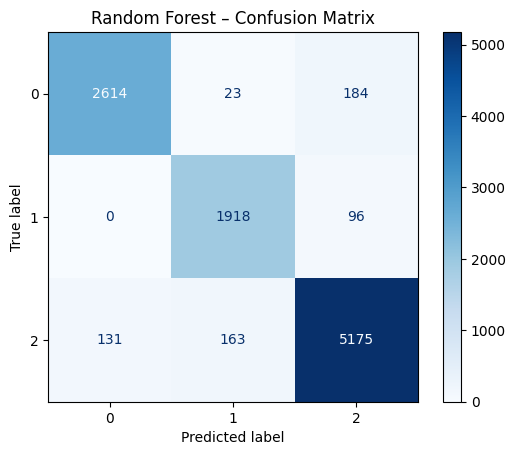

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf_pipeline,
    X_test,
    y_test,
    cmap="Blues"
)

plt.title("Random Forest – Confusion Matrix")
plt.show()


In [28]:
import pandas as pd

rf_model = rf_pipeline.named_steps["model"]

feature_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance


,feature,importance
3,debts,0.411022
2,monthly_expenses,0.254210
6,expense_to_income_ratio,0.214878
1,income_monthly,0.077830
5,age,0.010834
4,number_of_children,0.005566
9,health_status,0.005334
0,family_size,0.005160
8,housing_type,0.004904
7,case_type,0.004808


In [31]:
!pip install xgboost


In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
xgb_model = XGBClassifier(
    objective="multi:softprob",   # multi-class
    num_class=3,                  # Low / Medium / High
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)


In [34]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=3, ...)

In [35]:
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("XGBoost Accuracy:",
      accuracy_score(y_test, y_pred_xgb))

print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9469138198757764
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2821
           1       0.93      0.94      0.93      2014
           2       0.94      0.96      0.95      5469

    accuracy                           0.95     10304
   macro avg       0.95      0.94      0.94     10304
weighted avg       0.95      0.95      0.95     10304



In [36]:
# Prediction على Test Set
y_pred_log_test = log_pipeline.predict(X_test)

# Accuracy
log_acc = accuracy_score(y_test, y_pred_log_test)
print("Logistic Regression Test Accuracy:", log_acc)

# Classification Report
print("\nLogistic Regression – Classification Report")
print(classification_report(y_test, y_pred_log_test))


Logistic Regression Test Accuracy: 0.8840256211180124

Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2821
           1       0.80      0.92      0.86      2014
           2       0.94      0.84      0.89      5469

    accuracy                           0.88     10304
   macro avg       0.87      0.90      0.88     10304
weighted avg       0.89      0.88      0.88     10304



In [38]:
# Prediction على Test Set
y_pred_rf_test = rf_pipeline.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf_test)
print("Random Forest Test Accuracy:", rf_acc)

# Classification Report
print("\nRandom Forest – Classification Report")
print(classification_report(y_test, y_pred_rf_test))


Random Forest Test Accuracy: 0.9420613354037267

Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2821
           1       0.91      0.95      0.93      2014
           2       0.95      0.95      0.95      5469

    accuracy                           0.94     10304
   macro avg       0.94      0.94      0.94     10304
weighted avg       0.94      0.94      0.94     10304



In [39]:
# Prediction على Test Set
y_pred_rf_test = rf_pipeline.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf_test)
print("Random Forest Test Accuracy:", rf_acc)

# Classification Report
print("\nRandom Forest – Classification Report")
print(classification_report(y_test, y_pred_rf_test))


Random Forest Test Accuracy: 0.9420613354037267

Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2821
           1       0.91      0.95      0.93      2014
           2       0.95      0.95      0.95      5469

    accuracy                           0.94     10304
   macro avg       0.94      0.94      0.94     10304
weighted avg       0.94      0.94      0.94     10304



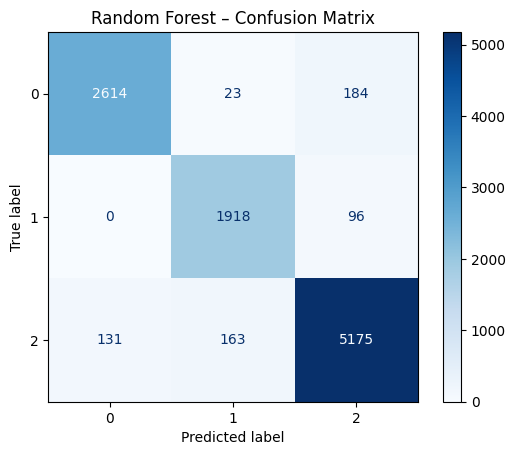

In [40]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf_test,
    cmap="Blues"
)
plt.title("Random Forest – Confusion Matrix")
plt.show()


In [41]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Test Accuracy": [log_acc, rf_acc]
})

comparison


,Model,Test Accuracy
0,Logistic Regression,0.884026
1,Random Forest,0.942061
